In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# plt.rcParams.update({"text.usetex": False,
#                      "font.size": 14,
#                      "pdf.fonttype": 42,
#                      "ps.fonttype": 42})
# plt.rcParams['xtick.labelsize']=12

In [3]:
map_key = "map_75"

In [4]:
jpeg_qualities = [60,70,80,90,100]
thresholds = [0.05, 0.1, 0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5]

In [5]:
time_dfs=[]
map_dfs = []
layers = []
for i in range(2,9):
    layers.append(i)
    time_dfs.append(pd.read_csv("../measurements/yolo_tiny_splitpoint/layer_"+str(i)+"/tensor_jpeg/time.csv"))
    map_dfs.append(pd.read_csv("../measurements/yolo_tiny_splitpoint/layer_"+str(i)+"/tensor_jpeg/map.csv"))
    # time_dfs.append(pd.read_csv("../measurements/yolo_tiny_splitpoint_cpu/layer_"+str(i)+"/tensor_jpeg/time.csv"))
    # map_dfs.append(pd.read_csv("../measurements/yolo_tiny_splitpoint_cpu/layer_"+str(i)+"/tensor_jpeg/map.csv"))

In [6]:
time_dfs[1].head()

,video_name,pruning_thresh,jepg_quality,head_time_mean,head_time_std,tail_time_mean,tail_time_std,framework_time_mean,framework_time_std,encode_time_mean,encode_time_std,decode_time_mean,decode_time_std,request_time_mean,request_time_std
0,b4fe0b47-a7819060,0.05,60,13.403217,0.877899,5.271707,0.119643,3.822052,0.122689,39.735471,3.857896,3.630332,0.841843,20.308451,1.609365
1,b4fe0b47-a7819060,0.05,70,13.746484,1.516702,5.267883,0.079721,3.831994,0.102137,40.726758,4.371719,3.833464,0.856007,20.775058,1.739377
2,b4fe0b47-a7819060,0.05,80,13.882263,1.291957,5.271076,0.078023,3.830821,0.103979,44.123037,4.069126,4.299345,0.996155,21.721286,1.674108
3,b4fe0b47-a7819060,0.05,90,13.471689,1.020161,5.313335,0.464223,3.817246,0.083099,48.393480,4.113668,5.171669,0.843503,23.572446,1.646880
4,b4fe0b47-a7819060,0.05,100,13.397766,1.211418,5.302741,0.477420,3.823240,0.083931,65.488282,5.787689,8.870792,0.724062,30.480660,2.016789


### Data size

In [7]:
datasizes={}
maps = {}
for layer in layers:
    index = layer -2
    df_group = map_dfs[index].groupby(["pruning_thresh","jepg_quality"])
    for key in df_group.groups.keys():
        dfg = df_group.get_group(key)
        datasizes[(layer,)+key] = dfg["data_size_mean"].mean()
        maps[(layer,)+key] = dfg[map_key].mean()


## Processing time

In [8]:
headtimes={}
encodetimes = {}
decodetimes ={}
tailtimes={}
overall_delays={}
for layer in layers:
    index = layer -2
    df_group = time_dfs[index].groupby(["pruning_thresh","jepg_quality"])
    for key in df_group.groups.keys():
        dfg = df_group.get_group(key)
        headtimes[(layer,)+key] = dfg["head_time_mean"].mean()
        encodetimes[(layer,)+key] = dfg["encode_time_mean"].mean()
        decodetimes[(layer,)+key] = dfg["decode_time_mean"].mean()
        tailtimes[(layer,)+key] = dfg["tail_time_mean"].mean()
        overall_delays[(layer,)+key] = dfg["head_time_mean"].mean() + dfg["encode_time_mean"].mean()+ dfg["request_time_mean"].mean()
        # maps[(layer,)+key] = dfg[map_key].mean()

## Plots

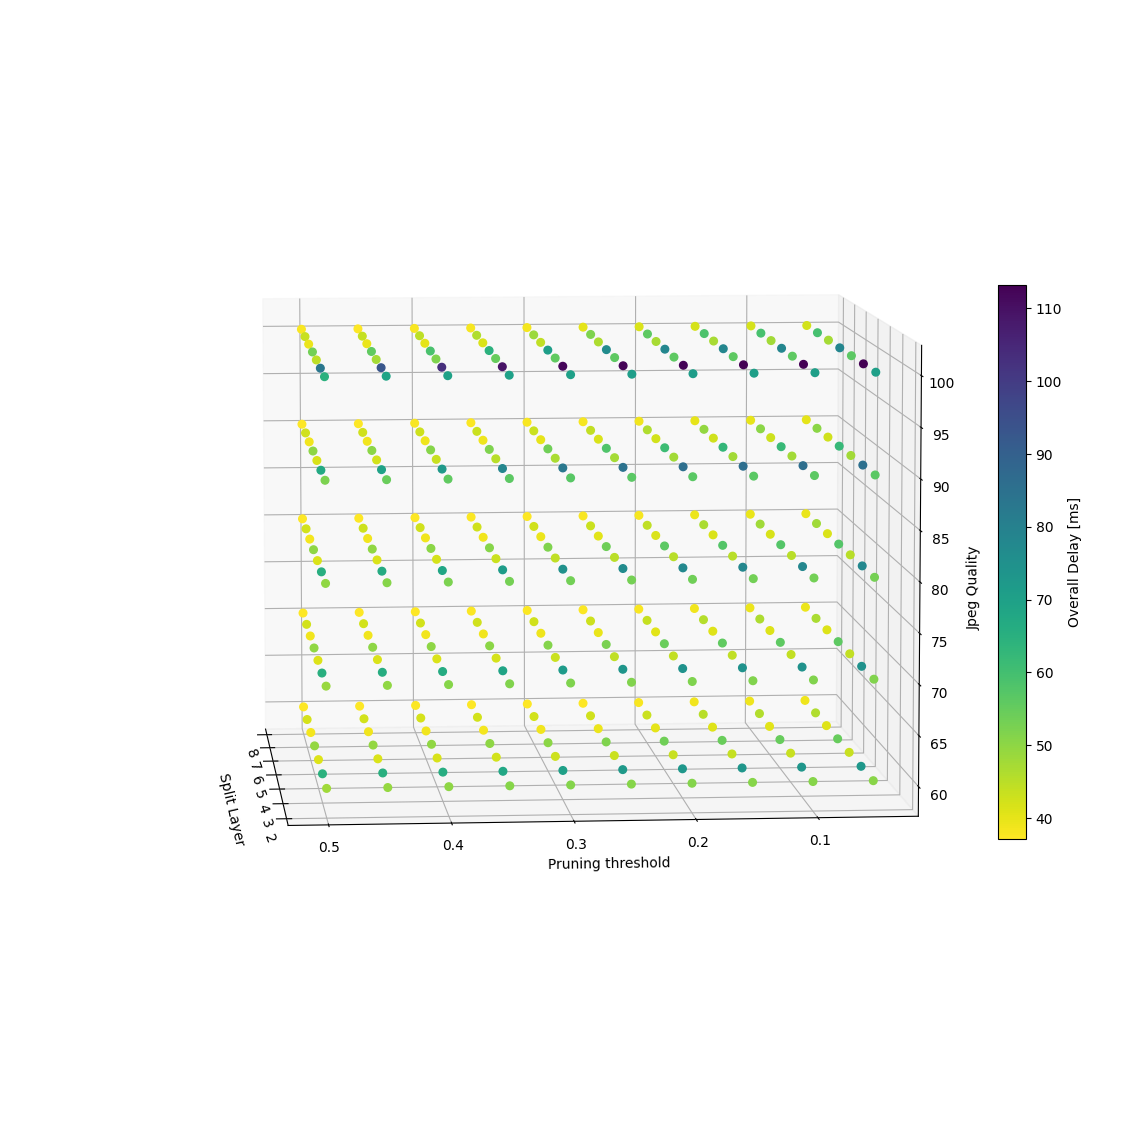

In [9]:
fig = plt.figure(figsize=[15,18])
ax = fig.add_subplot(projection='3d')

colors=["tab:blue","tab:green","tab:orange","tab:purple","tab:brown","tab:pink","tab:cyan"]
x=[]
y=[]
z=[]
v=[]
# layer_plot = [2,4,6,8]
for l in layers:
    for thresh in thresholds:
        for quality in jpeg_qualities:
            encodetime = overall_delays[(l,thresh,quality)]
            x.append(l)
            y.append(thresh)
            z.append(quality)
            v.append(encodetime)

sc = ax.scatter(x,y,z, c=v, marker="o",cmap='viridis_r',s=30, alpha=1)


ax.tick_params(axis='x', labelrotation=290)
ax.set_xlabel('Split Layer',labelpad=10)
ax.set_ylabel('Pruning threshold',labelpad=10)
ax.set_zlabel('Jpeg Quality',labelpad=10)
# plt.legend()
plt.colorbar(sc,shrink=0.4,pad=-0.1,label="Overall Delay [ms]")

# # On the y-axis let's only label the discrete values that we have data for.
# ax.set_yticks(yticks)
ax.view_init(7, 175, 0)

ax.set_box_aspect(None, zoom=0.85)
plt.show()
#


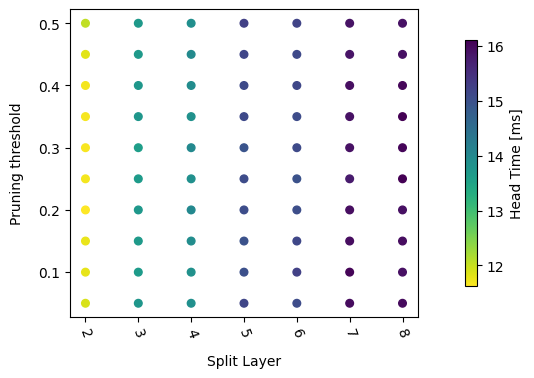

In [10]:
fig = plt.figure(figsize=[6,4])
# ax = fig.add_subplot(projection='3d')
ax = fig.add_subplot()
colors=["tab:blue","tab:green","tab:orange","tab:purple","tab:brown","tab:pink","tab:cyan"]
x=[]
y=[]
z=[]
v=[]
# layer_plot = [2,4,6,8]
for l in layers:
    for thresh in thresholds:
        for quality in [90]:
            headtiem = headtimes[(l,thresh,quality)]
            x.append(l)
            y.append(thresh)
            z.append(quality)
            v.append(headtiem)

sc = ax.scatter(x,y, c=v, marker="o",cmap='viridis_r',s=30, alpha=1)


# for quality in jpeg_qualities:
#     x_temp=[]
#     y_temp=[]
#     z_temp=[]
#     for l in layers:
#         thresh_min = 0.8
#         l_temp = np.nan
#         quality_temp = np.nan
#         for thresh in thresholds:
#             if  datasizes[(l,thresh,quality)]/1e3 <50 and thresh<thresh_min:
#                 thresh_min = thresh
#                 l_temp = l
#                 quality_temp=quality
#         x_temp.append(l_temp)
#         y_temp.append(thresh_min)
#         z_temp.append(quality_temp)
#     if len(x_temp)!=0:
#         ax.plot3D(x_temp,y_temp,z_temp,color="tab:red")



ax.tick_params(axis='x', labelrotation=290)
ax.set_xlabel('Split Layer',labelpad=10)
ax.set_ylabel('Pruning threshold',labelpad=10)
# ax.set_zlabel('Jpeg Quality',labelpad=10)
# plt.legend()
plt.colorbar(sc,shrink=0.8,pad=0.1,label="Head Time [ms]")

# # On the y-axis let's only label the discrete values that we have data for.
# ax.set_yticks(yticks)
# ax.view_init(7, 175, 0)

# ax.set_box_aspect(None, zoom=0.85)
plt.show()
#


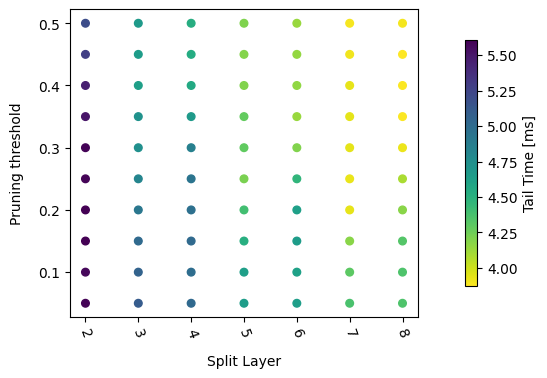

In [11]:
fig = plt.figure(figsize=[6,4])
# ax = fig.add_subplot(projection='3d')
ax = fig.add_subplot()
colors=["tab:blue","tab:green","tab:orange","tab:purple","tab:brown","tab:pink","tab:cyan"]
x=[]
y=[]
z=[]
v=[]
# layer_plot = [2,4,6,8]
for l in layers:
    for thresh in thresholds:
        for quality in [90]:
            headtiem = tailtimes[(l,thresh,quality)]
            x.append(l)
            y.append(thresh)
            z.append(quality)
            v.append(headtiem)

sc = ax.scatter(x,y, c=v, marker="o",cmap='viridis_r',s=30, alpha=1)


# for quality in jpeg_qualities:
#     x_temp=[]
#     y_temp=[]
#     z_temp=[]
#     for l in layers:
#         thresh_min = 0.8
#         l_temp = np.nan
#         quality_temp = np.nan
#         for thresh in thresholds:
#             if  datasizes[(l,thresh,quality)]/1e3 <50 and thresh<thresh_min:
#                 thresh_min = thresh
#                 l_temp = l
#                 quality_temp=quality
#         x_temp.append(l_temp)
#         y_temp.append(thresh_min)
#         z_temp.append(quality_temp)
#     if len(x_temp)!=0:
#         ax.plot3D(x_temp,y_temp,z_temp,color="tab:red")



ax.tick_params(axis='x', labelrotation=290)
ax.set_xlabel('Split Layer',labelpad=10)
ax.set_ylabel('Pruning threshold',labelpad=10)
# ax.set_zlabel('Jpeg Quality',labelpad=10)
# plt.legend()
plt.colorbar(sc,shrink=0.8,pad=0.1,label="Tail Time [ms]")

# # On the y-axis let's only label the discrete values that we have data for.
# ax.set_yticks(yticks)
# ax.view_init(7, 175, 0)
# plt.grid()
# ax.set_box_aspect(None, zoom=0.85)
plt.show()
#


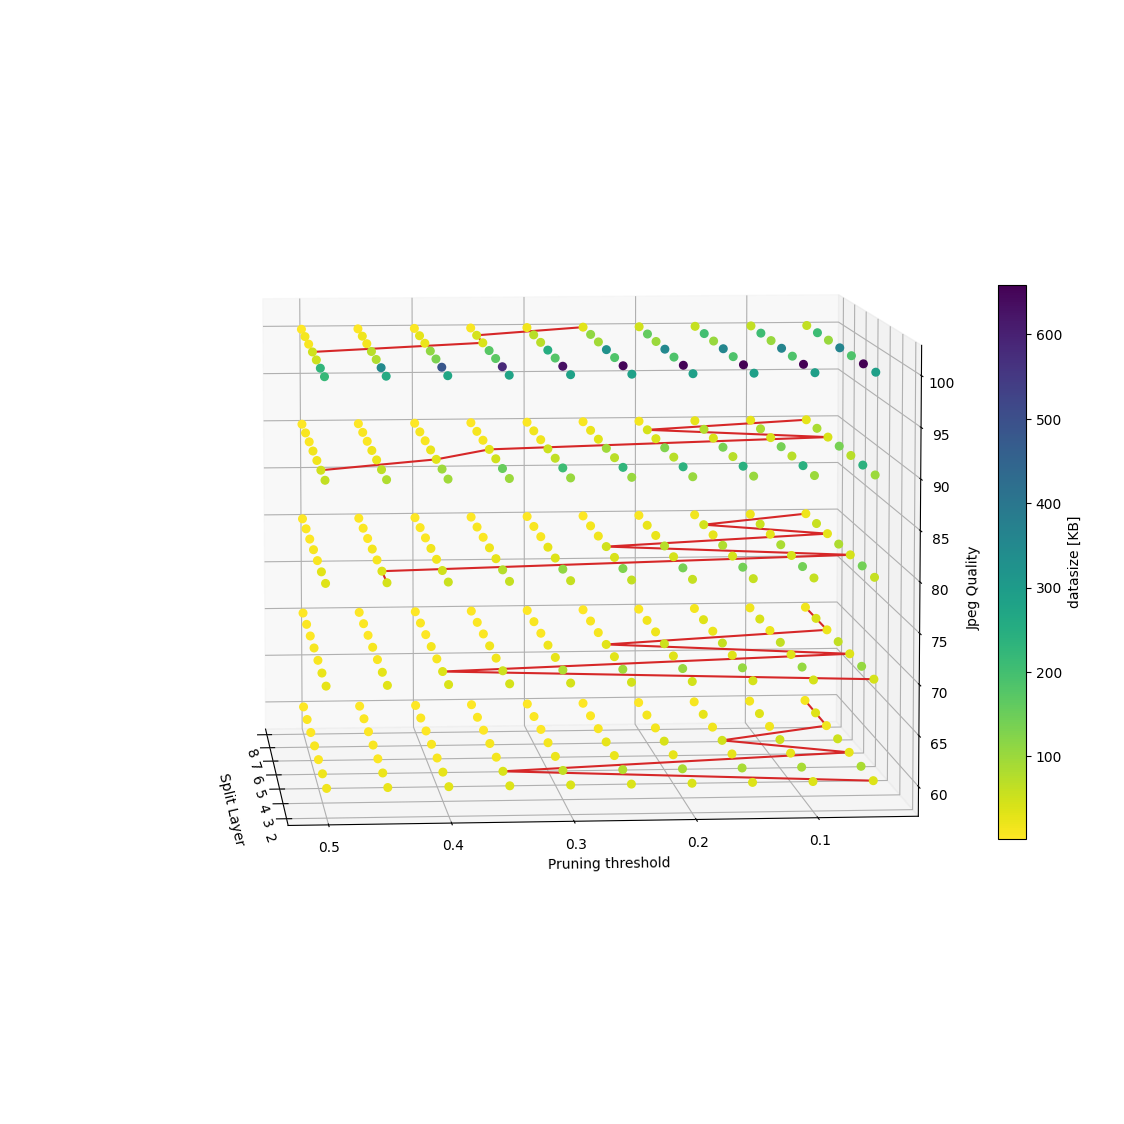

In [12]:
fig = plt.figure(figsize=[15,18])
ax = fig.add_subplot(projection='3d')

colors=["tab:blue","tab:green","tab:orange","tab:purple","tab:brown","tab:pink","tab:cyan"]
x=[]
y=[]
z=[]
v=[]
# layer_plot = [2,4,6,8]
for l in layers:
    for thresh in thresholds:
        for quality in jpeg_qualities:
            datasize = datasizes[(l,thresh,quality)]/1e3
            x.append(l)
            y.append(thresh)
            z.append(quality)
            v.append(datasize)

sc = ax.scatter(x,y,z, c=v, marker="o",cmap='viridis_r',s=30, alpha=1)


for quality in jpeg_qualities:
    x_temp=[]
    y_temp=[]
    z_temp=[]
    for l in layers:
        thresh_min = 0.8
        l_temp = np.nan
        quality_temp = np.nan
        for thresh in thresholds:
            if  datasizes[(l,thresh,quality)]/1e3 <50 and thresh<thresh_min:
                thresh_min = thresh
                l_temp = l
                quality_temp=quality
        x_temp.append(l_temp)
        y_temp.append(thresh_min)
        z_temp.append(quality_temp)
    if len(x_temp)!=0:
        ax.plot3D(x_temp,y_temp,z_temp,color="tab:red")



ax.tick_params(axis='x', labelrotation=290)
ax.set_xlabel('Split Layer',labelpad=10)
ax.set_ylabel('Pruning threshold',labelpad=10)
ax.set_zlabel('Jpeg Quality',labelpad=10)
# plt.legend()
plt.colorbar(sc,shrink=0.4,pad=-0.1,label="datasize [KB]")

# # On the y-axis let's only label the discrete values that we have data for.
# ax.set_yticks(yticks)
ax.view_init(7, 175, 0)

ax.set_box_aspect(None, zoom=0.85)
plt.show()
#


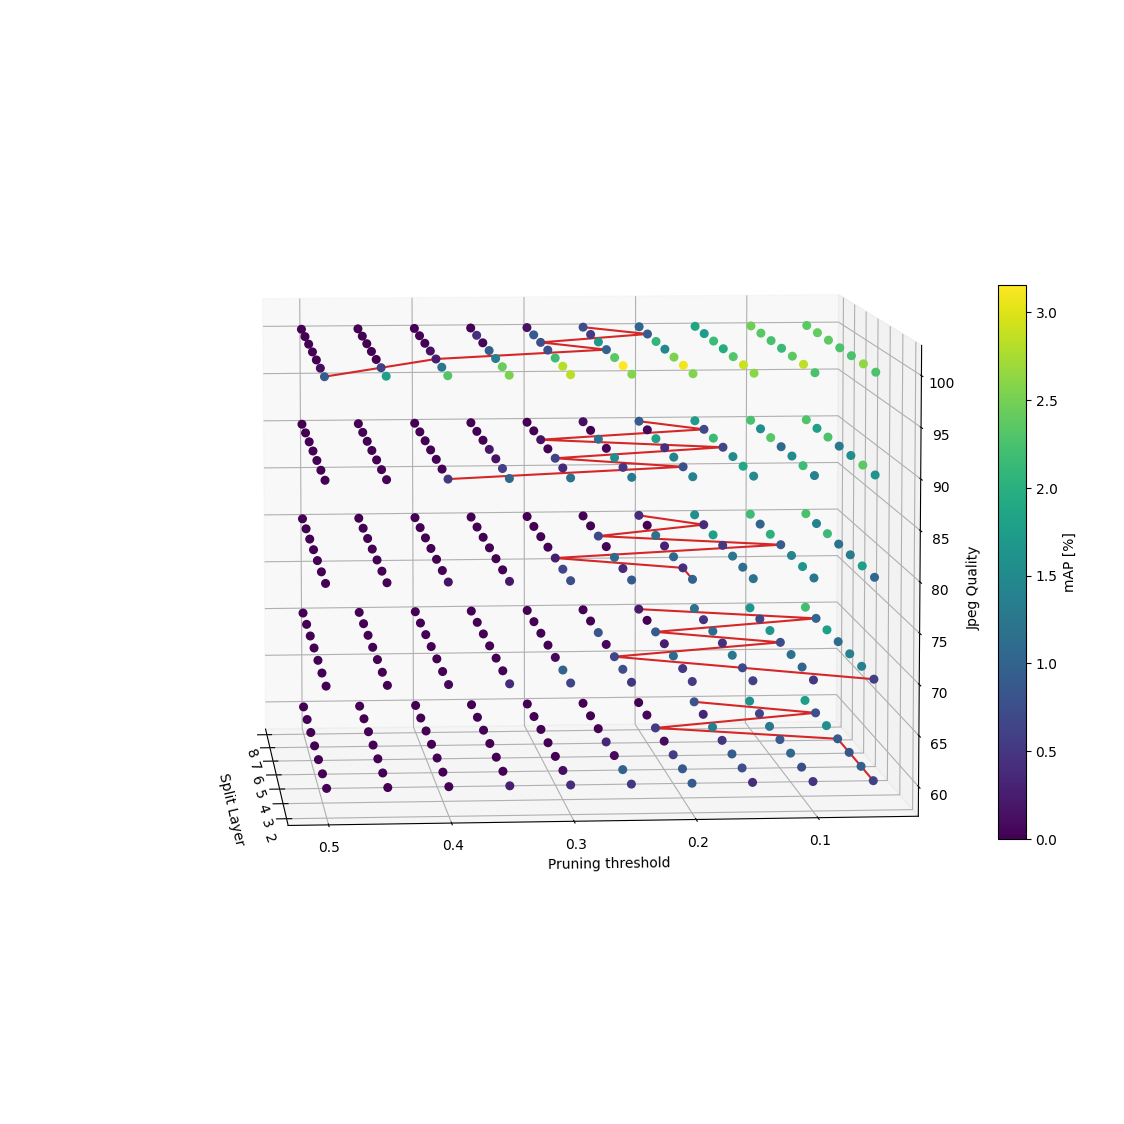

In [13]:

fig = plt.figure(figsize=[15,18])
ax = fig.add_subplot(projection='3d')

colors=["tab:blue","tab:green","tab:orange","tab:purple","tab:brown","tab:pink","tab:cyan"]
x=[]
y=[]
z=[]
v=[]
# layer_plot = [2,4,6,8]
for l in layers:
    for thresh in thresholds:
        for quality in jpeg_qualities:
            map = maps[(l,thresh,quality)]*100
            x.append(l)
            y.append(thresh)
            z.append(quality)
            v.append(map)
    
sc = ax.scatter(x,y,z, c=v, marker="o",cmap='viridis',s=30, alpha=1)


for quality in jpeg_qualities:
    x_temp=[]
    y_temp=[]
    z_temp=[]
    for l in layers:
        thresh_min = 0.8
        l_temp = np.nan
        quality_temp = np.nan
        for thresh in thresholds:
            if  maps[(l,thresh,quality)]*100<1 and thresh<thresh_min:
                thresh_min = thresh
                l_temp = l
                quality_temp=quality
        x_temp.append(l_temp)
        y_temp.append(thresh_min)
        z_temp.append(quality_temp)
    if len(x_temp)!=0:
        ax.plot3D(x_temp,y_temp,z_temp,color="tab:red")




ax.tick_params(axis='x', labelrotation=290)
ax.set_xlabel('Split Layer',labelpad=10)
ax.set_ylabel('Pruning threshold',labelpad=10)
ax.set_zlabel('Jpeg Quality',labelpad=10)
# plt.legend()
plt.colorbar(sc,shrink=0.4,pad=-0.1,label="mAP [%]")

# # On the y-axis let's only label the discrete values that we have data for.
# ax.set_yticks(yticks)
ax.view_init(7, 175, 0)

ax.set_box_aspect(None, zoom=0.85)
plt.show()
#


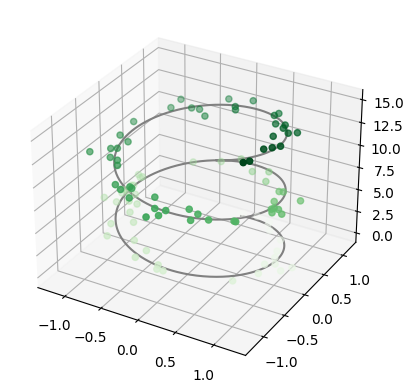

In [14]:
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
zline = np.linspace(0, 15, 1000)
xline = np.sin(zline)
yline = np.cos(zline)
ax.plot3D(xline, yline, zline, 'gray')

# Data for three-dimensional scattered points
zdata = 15 * np.random.random(100)
xdata = np.sin(zdata) + 0.1 * np.random.randn(100)
ydata = np.cos(zdata) + 0.1 * np.random.randn(100)
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens')

In [15]:
len(xline)

1000

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


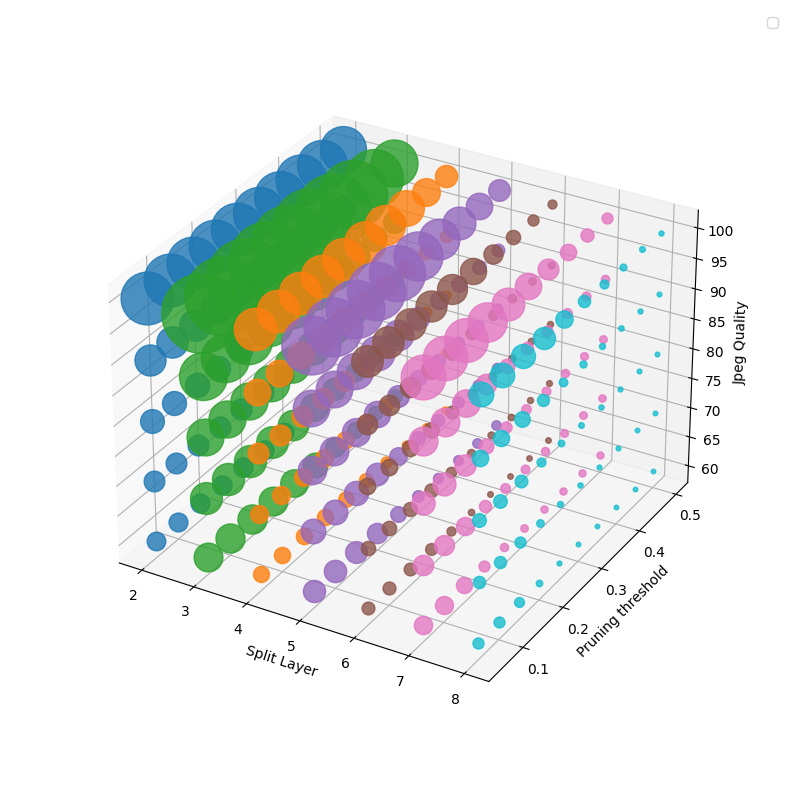

In [16]:
fig = plt.figure(figsize=[10,15])
ax = fig.add_subplot(projection='3d')

colors=["tab:blue","tab:green","tab:orange","tab:purple","tab:brown","tab:pink","tab:cyan"]

layer_plot = [2,4,6,8]
for l in layers:
    for thresh in thresholds:
        for quality in jpeg_qualities:
            data_size = datasizes[(l,thresh,quality)]/1e3
            # ax.scatter(l,quality,zs=thresh, zdir='y',marker="o", s=data_size*100, alpha=0.8)
            ax.scatter(l, thresh,quality, marker="o",s=data_size*5,color=colors[l-2], alpha=0.8)
    # ax1.plot(jpeg_qualities,data_size, "*-", label="thr= "+str(thresh) )

    # You can provide either a single color or an array with the same length as
    # xs and ys. To demonstrate this, we color the first bar of each set cyan.
    # Plot the bar graph given by xs and ys on the plane y=k with 80% opacity.
    
# ax.view_init(6, 5, 0)
ax.set_xlabel('Split Layer')
ax.set_ylabel('Pruning threshold')
ax.set_zlabel('Jpeg Quality')
plt.legend()
# # On the y-axis let's only label the discrete values that we have data for.
# ax.set_yticks(yticks)
ax.set_box_aspect(None, zoom=0.85)
plt.grid()
plt.show()

C:\Users\d069182\AppData\Local\Temp\ipykernel_29244\2408702981.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


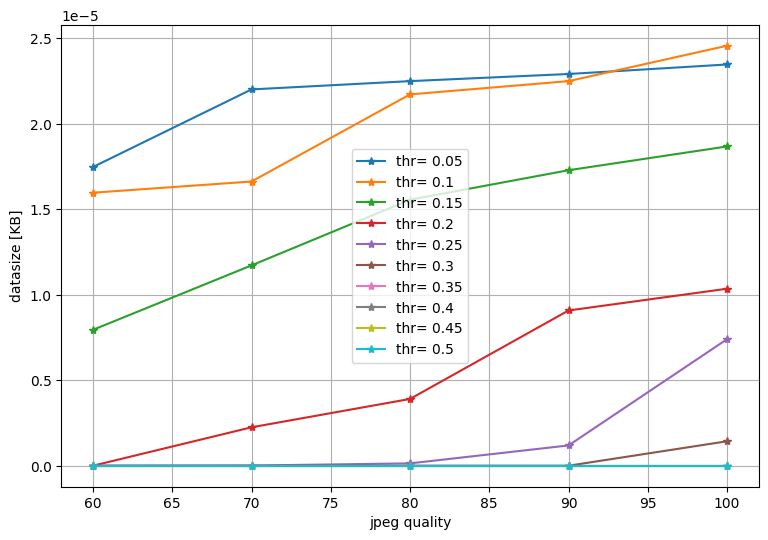

In [17]:
fig, ax1 = plt.subplots(figsize=(9, 6))

ploting_splitpoint =8 
for thresh in thresholds:
    data_size = []
    for quality in jpeg_qualities:
        data_size.append(maps[(ploting_splitpoint,thresh,quality)]/1e3)
    ax1.plot(jpeg_qualities,data_size, "*-", label="thr= "+str(thresh) )


ax1.set_ylabel("datasize [KB]")
ax1.set_xlabel('jpeg quality')
# ax1.set_xticks(x_real, x_real)
ax1.legend()
ax1.autoscale(axis="x",tight=False)
ax1.grid()
fig.show()

C:\Users\d069182\AppData\Local\Temp\ipykernel_29244\2513132037.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


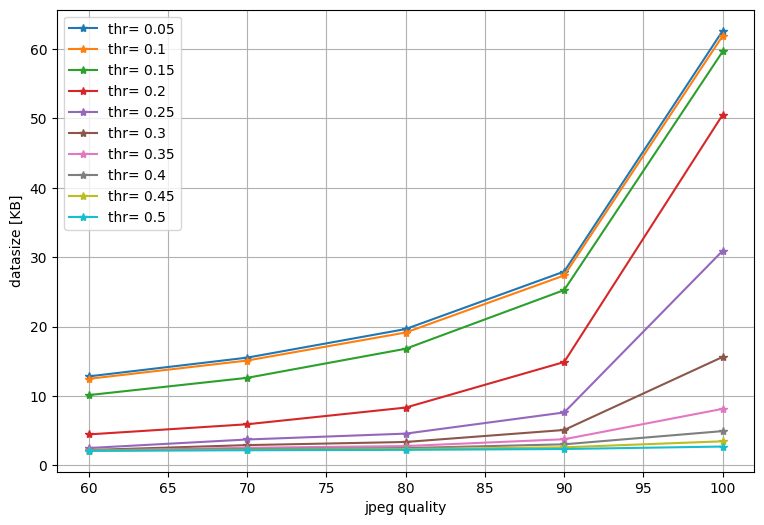

In [18]:
fig, ax1 = plt.subplots(figsize=(9, 6))

ploting_splitpoint =8 
for thresh in thresholds:
    data_size = []
    for quality in jpeg_qualities:
        data_size.append(datasizes[(ploting_splitpoint,thresh,quality)]/1e3)
    ax1.plot(jpeg_qualities,data_size, "*-", label="thr= "+str(thresh) )


ax1.set_ylabel("datasize [KB]")
ax1.set_xlabel('jpeg quality')
# ax1.set_xticks(x_real, x_real)
ax1.legend()
ax1.autoscale(axis="x",tight=False)
ax1.grid()
fig.show()